In [1]:
import convex_return_mapping as crm # there is a conflict in the oder of imported modules

import meshio
from mpi4py import MPI

import plasticity_framework 
import sys
sys.path.append("../")
import fenicsx_support as fs
# from dolfinx import fem, io

import matplotlib.pyplot as plt


In [2]:
import numpy as np


In [3]:
def plot_displacement(results):
    plt.plot(results[:, 0], results[:, 1], "-o")
    plt.xlabel("Displacement of inner boundary")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.show()

In [4]:
if MPI.COMM_WORLD.rank == 0:
    #It works with the msh4 only!!
    msh = meshio.read("thick_cylinder_coarse.msh")

    # Create and save one file for the mesh, and one file for the facets 
    triangle_mesh = fs.create_mesh(msh, "triangle", prune_z=True)
    line_mesh = fs.create_mesh(msh, "line", prune_z=True)
    meshio.write("thick_cylinder.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)
    print(msh)
    


<meshio mesh object>
  Number of points: 50
  Number of cells:
    line: 2
    line: 14
    line: 2
    line: 11
    triangle: 69
  Cell sets: gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical


In [5]:
s = "thick_cylinder_coarse.msh"
type(s)

str

In [4]:
Pa_dim = 70e3
E = 70e3 / Pa_dim #[-]
nu = 0.3 #[-]

sig0 = 250 / Pa_dim #[-]
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus


nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
du 0.0009941219182566228 0.0 0.011968600503365713
C_tang 1.346153846153845 -1.385690519923303e-08
C_tang relative error 3.524958390180334e-09 4.507273433160922e-09
    Residual: 7.350540377431972e-16
p after copy 7.694529716358323e-18 8.490047458393111e-19 0.0
	rank#0: Time (convex_solving) = 0.00171 (s)
	rank#0: Time (convex_solving_cvxpy) = 0.00081 (s)
	rank#0: Time (differentiation) = 0.00888 (s)
	rank#0: Time (return_mapping) = 2.21113 (s)
	rank#0: Time (differentiation_total) = 1.83768 (s)
	rank#0: Time (convex_solving_total) = 0.35459 (s)

nRes0 , 3.688449012011855e-05 
 Increment: 2, load = 0.00035884951272532715
du 0.00041177877967277856 0.0 0.004957556646660604
C_tang 1.3461538461538396 -2.7730820336601398e-08
C_tang relative error 6.907500922106464e-09 8.970410392388045e-09
    Residual: 9.938144639955788e-13
p after copy 7.354664365454652e-12 3.736495132667795e-18 0.0
	rank#0: Time (convex_solving) =

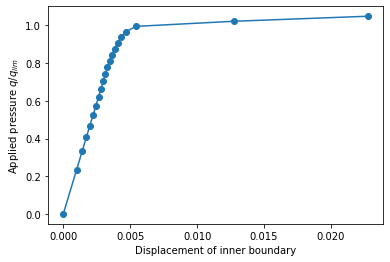

In [5]:
alpha = 0
vonMises = crm.vonMises(sig0, H)
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
points_on_proc, results = plasticity_framework.solve_convex_plasticity_interpolation(sig0, material, 3)

if len(points_on_proc) > 0:
    plot_displacement(results)

In [9]:
alpha = np.tan(60*np.pi/180)
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
points_on_proc, results_60 = plasticity_framework.solve_convex_plasticity_interpolation(sig0, material, 3)

if len(points_on_proc) > 0:
    plot_displacement(results_60)


nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
du 0.0009941219182566228 0.0 0.011968600503365713
C_tang 1.34615384619914 -1.524293280470659e-08
C_tang relative error 3.047303229610457e-09 5.5956329134935365e-09
    Residual: 2.6180542041075497e-14
p after copy 1.077284341950963e-11 1.6031819583899437e-14 0.0
	rank#0: Time (convex_solving) = 0.00168 (s)
	rank#0: Time (convex_solving_cvxpy) = 0.00083 (s)
	rank#0: Time (differentiation) = 0.00897 (s)
	rank#0: Time (return_mapping) = 2.22369 (s)
	rank#0: Time (differentiation_total) = 1.85694 (s)
	rank#0: Time (convex_solving_total) = 0.34877 (s)

nRes0 , 3.688449011904315e-05 
 Increment: 2, load = 0.00035884951272532715
du 0.0004117787819026752 0.0 0.004957556659562222
C_tang 1.3461538462050198 -0.0693330239491939
C_tang relative error 0.13566368606194748 0.18804585533824864
    Residual: 1.7036461045016703e-05
du 1.4511713045388119e-05 0.0 0.00018160678551417712
C_tang 1.3461538461855647 -0.06602064204261172

KeyboardInterrupt: 


nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
du 0.0009941219182566228 0.0 0.011968600503365713
C_tang 1.3461538461793987 -6.619453537503964e-09
C_tang relative error 1.2406089247291672e-09 2.5124766901910807e-09
    Residual: 4.9461226935090735e-16
p after copy 1.1166429427504344e-11 1.4955244927541441e-18 0.0
	rank#0: Time (convex_solving) = 0.00388 (s)
	rank#0: Time (convex_solving_cvxpy) = 0.00177 (s)
	rank#0: Time (differentiation) = 0.00899 (s)
	rank#0: Time (return_mapping) = 2.70807 (s)
	rank#0: Time (differentiation_total) = 1.86172 (s)
	rank#0: Time (convex_solving_total) = 0.80341 (s)

nRes0 , 3.688449012025298e-05 
 Increment: 2, load = 0.00035884951272532715
du 0.0004117787800107665 0.0 0.0049575566444515495
C_tang 1.346153846201634 -2.442654564541547e-08
C_tang relative error 2.3704861674901577e-09 5.290331102118878e-09
    Residual: 6.028929697566723e-13
p after copy 1.9323668424534444e-11 1.9596828429027566e-14 0.0
	rank#0: Time (convex_sol

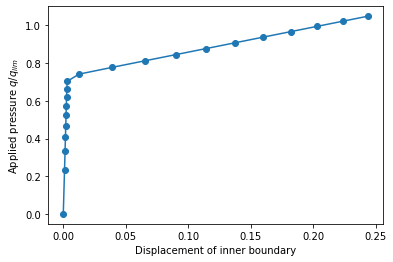

In [8]:
alpha = np.tan(45*np.pi/180)
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
points_on_proc, results_45 = plasticity_framework.solve_convex_plasticity_interpolation(sig0, material, 1)

if len(points_on_proc) > 0:
    plot_displacement(results_45)


nRes0 , 8.904703628988367e-05 
 Increment: 1, load = 0.0002537449238735671
du 0.0009941219182566228 0.0 0.011968600503365713
C_tang 1.3461538461747102 -1.7442376743512014e-08
C_tang relative error 2.3287691059656234e-09 4.663893389939659e-09
    Residual: 6.193403282196335e-16
p after copy 1.0821069403914617e-11 8.692600919319075e-19 0.0
	rank#0: Time (convex_solving) = 0.00399 (s)
	rank#0: Time (convex_solving_cvxpy) = 0.00182 (s)
	rank#0: Time (differentiation) = 0.00930 (s)
	rank#0: Time (return_mapping) = 2.79329 (s)
	rank#0: Time (differentiation_total) = 1.92437 (s)
	rank#0: Time (convex_solving_total) = 0.82583 (s)

nRes0 , 3.688449012023666e-05 
 Increment: 2, load = 0.00035884951272532715
du 0.00041177877838603094 0.0 0.004957556631973069
C_tang 1.3461538461919713 -3.835465491964918e-08
C_tang relative error 5.5158691520362664e-09 1.0830546256648598e-08
    Residual: 9.850356014957099e-13
p after copy 1.9356347515374237e-11 2.316867220788844e-14 0.0
	rank#0: Time (convex_solv

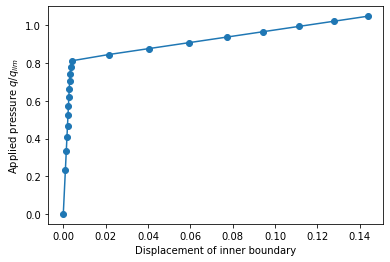

In [7]:
alpha = np.tan(30*np.pi/180)
DruckerPrager = crm.DruckerPrager(sig0, alpha, H)
material = crm.Material(crm.IsotropicElasticity(E, nu), DruckerPrager)
points_on_proc, results_30 = plasticity_framework.solve_convex_plasticity_interpolation(sig0, material, 1)

if len(points_on_proc) > 0:
    plot_displacement(results_30)